# Dirichlet example from Maier

Based on http://dirichletreg.r-forge.r-project.org/


In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import ternary
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os
import arviz as az
from matplotlib.patches import Ellipse, transforms
from itertools import combinations
#import ternary

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

This example from Marco Maier gives the regular (and flexible) parameterization of a Dirichlet linear model for habitat types (sand, slit, and clay) in an Arctic lake.

In [39]:
# Import data
AL = pd.read_csv("ArcticLake.csv")
AL.head()

# Grab habitat names
hnames = list(AL.columns.values[:-1])

# Format data
DEP = stdize(AL.depth.values)
AL.drop('depth',axis=1,inplace=True)
y = AL.values
# Make y's sum to 1
y = y/y.sum(axis=1,keepdims=1)
nhabs = y.shape[1]

array([-0.6790595 , -0.65560537, -0.63575957, -0.63215124, -0.58343882,
       -0.57261384, -0.54194305, -0.5293139 , -0.49323063, -0.46797233,
       -0.46255984, -0.42647657, -0.40121827, -0.2803393 , -0.2604935 ,
       -0.20276026, -0.18471862, -0.20095609, -0.10533541, -0.01873555,
       -0.01693138,  0.00652275,  0.02456438,  0.02636855,  0.20137244,
        0.21760991,  0.24647653,  0.25910568,  0.38359298,  0.46117202,
        0.47560534,  0.54957605,  0.62895926,  0.71555912,  0.72277578,
        0.76427154,  0.76787987,  0.8959755 ,  1.00422533])

We can take a look at the relative proportions using a ternary plot

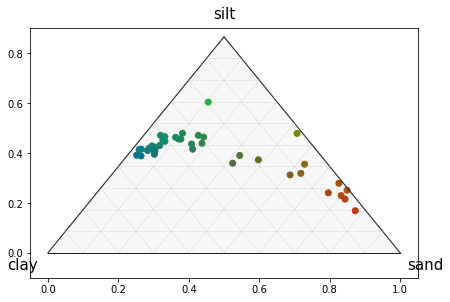

In [3]:
figure, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.)
tax.gridlines(multiple=.1, color="darkgrey")
tax.scatter(y, c=y, cmap = "magma")
tax.right_corner_label('sand', fontsize=15)
tax.left_corner_label('clay', fontsize=15)
tax.top_corner_label('silt', fontsize=15)
plt.tight_layout();

And the code to bulid the model in PyMC is relatively straightforward

In [32]:
with pm.Model() as BDM:
    intercept = pm.Normal('intercept', 0, 2, shape=nhabs)
    depth = pm.Normal('depth', 0, 1, shape=nhabs)
    depth2 = pm.Normal('depth2', 0, 1, shape=nhabs)

    α = pm.Deterministic('alpha', tt.exp(intercept+depth*DEP[:,None]+depth2*DEP[:,None]**2) )
    Yi = pm.Dirichlet('Yi', α, observed=y)

Note the `[:,None]` in the code is to broadcast the depth measurements across all three habitats.

In [33]:
for RV in BDM.basic_RVs:
    print(RV.name, RV.logp(BDM.test_point))

intercept -4.836257141293855
depth -2.756815599614018
depth2 -2.756815599614018
Yi 27.032740041837897


In [34]:
with BDM:
    trace_dm = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [depth2, depth, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


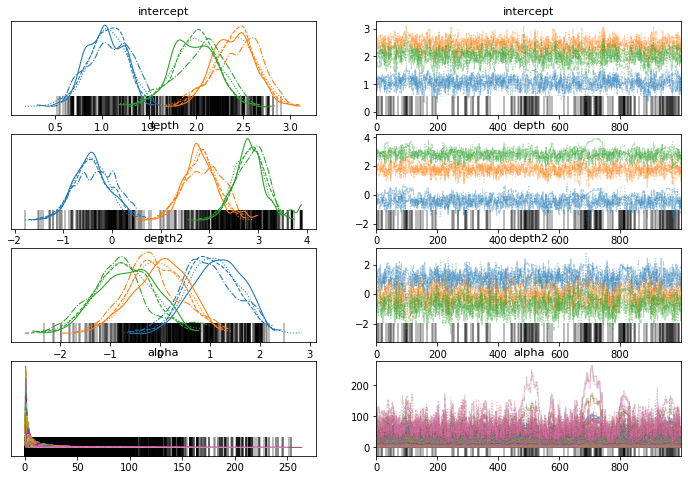

In [11]:
pm.traceplot(trace_dm);

In [12]:
pm.summary(trace_dm, var_names=['intercept', 'depth', 'depth2'])

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[0],1.058,0.213,0.660,1.444,0.011,0.008,350.0,681.0,1.01
intercept[1],2.419,0.233,1.979,2.853,0.012,0.008,418.0,419.0,1.01
intercept[2],2.001,0.245,1.526,2.437,0.013,0.009,364.0,312.0,1.01
depth[0],-0.393,0.390,-1.096,0.362,0.022,0.016,321.0,241.0,1.01
depth[1],1.829,0.364,1.173,2.536,0.022,0.017,279.0,170.0,1.01
depth[2],2.843,0.324,2.229,3.437,0.019,0.014,309.0,211.0,1.01
depth2[0],1.056,0.519,0.173,2.045,0.028,0.020,336.0,446.0,1.02
depth2[1],-0.062,0.548,-1.066,0.967,0.028,0.020,380.0,488.0,1.02
depth2[2],-0.716,0.593,-1.819,0.378,0.032,0.022,349.0,301.0,1.02


In [12]:
# Grab alphas
alpha = trace_dm['alpha'].T
alpha_0 = alpha.sum(0).mean(1)

In [13]:
# Grab expected alphas
Ex_alphas = alpha.mean(2)
Ex = Ex_alphas/alpha_0

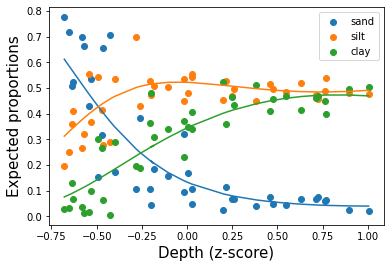

In [14]:
# Plot estimates against observed
[plt.scatter(DEP,yi,label=l) for yi,l in zip(y.T,hnames)]
[plt.plot(DEP,ei) for ei in Ex]
plt.ylabel('Expected proportions', fontsize=15)
plt.xlabel('Depth (z-score)', fontsize=15)
plt.legend();

The plot above of the expected change in proportions with depth looks great - but this is on the probability scale, abd these lines wiggle quite a lot given that the underlying model is a second order polynomial. How is this possible? Well the lines are relative to one another based on the simplex (i.e. that they all sum to one), and their expectation is a ratio relative to the total sum:

$$
E(y_i) = \frac{\alpha_i}{\alpha_0}
$$


To see what the underlying polynomials look like (on the $[0,\infty]$ scale) we can look at the alphas against depth:

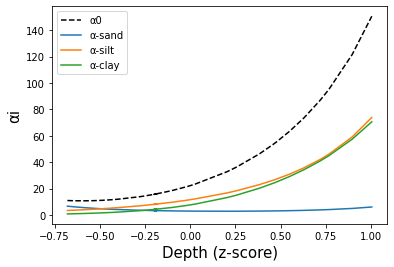

In [15]:
# Plot alphas vs depth
plt.plot(DEP, alpha_0, linestyle='--', c='black', label='α0')
[plt.plot(DEP, a, label='α-'+l) for a,l in zip(Ex_alphas,hnames)]
plt.ylabel('αi', fontsize=15)
plt.xlabel('Depth (z-score)', fontsize=15)
plt.legend();